In [5]:
%matplotlib inline
import autorootcwd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter, medfilt
from datetime import datetime
import matplotlib.dates as mdates
import nbimporter
from src.utils import convert_csi_to_amplitude, plot_csi_amplitude
from src.preprocessing import z_normalization, filter_normalization, robust_hampel, detrending_amp, extract_motion_features, detect_activity_with_ewma

ACTIVITY_CSI_PATH = r"data\raw\raw_activity_csi\merged_csi_data_dooropen.csv"
NO_ACTIVITY_CSI_PATH = r"data\raw\raw_noactivity_csi\merged_csi_data_noactivity.csv"


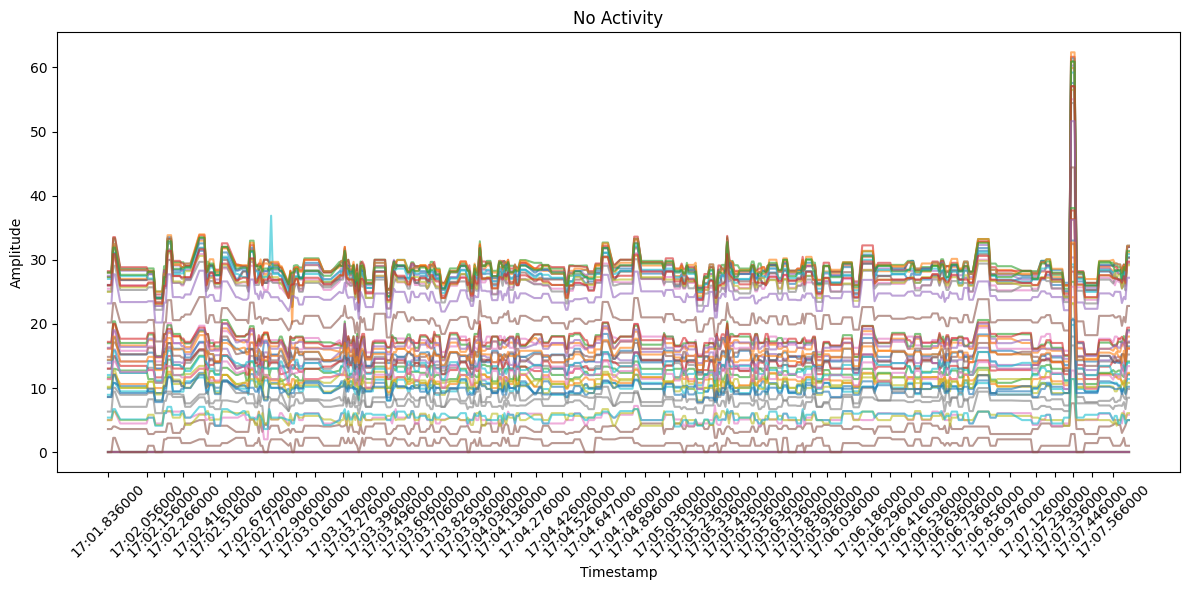

In [7]:
# raw 데이터 로드 
amp , ts = convert_csi_to_amplitude(NO_ACTIVITY_CSI_PATH, SUBCARRIER_NUM=52)
plot_csi_amplitude(amp, ts, title="No Activity")

#### 전체 변화를 잘 대표하는 서브캐리어 찾기


In [1]:
def find_best_subcarrier(detrended, target_signal, WIN_SIZE=100) :
    '''
    Desc : 전체 변화를 잘 대표하는 서브캐리어 찾기
    param detrended : 전처리된 데이터
    param target_signal : 목표 신호
    param WIN_SIZE : 윈도우 크기
    return : 최적의 서브캐리어 번호
    '''
    correlations = [] 

    for i in range(detrended.shape[1]):
        signal = np.abs(np.diff(detrended[:, i])) #  모든 서브캐리어에 대해 extract_motion_features() 적용
        
        # 이동 평균 (같은 방식으로 맞춰줘야 비교 가능)
        padded = np.concatenate([np.zeros(WIN_SIZE), signal])
        conv = np.convolve(padded, np.ones(WIN_SIZE), mode='valid')
        smoothed_sc = conv[-len(signal):]

        # 길이 맞춰서 비교
        min_len = min(len(smoothed_sc), len(target_signal))
        corr = np.corrcoef(smoothed_sc[:min_len], target_signal[:min_len])[0, 1]
        correlations.append(corr)

        best_subcarrier = int(np.argmax(correlations))
        print(f"Best Subcarrier: {best_subcarrier}")
    return best_subcarrier


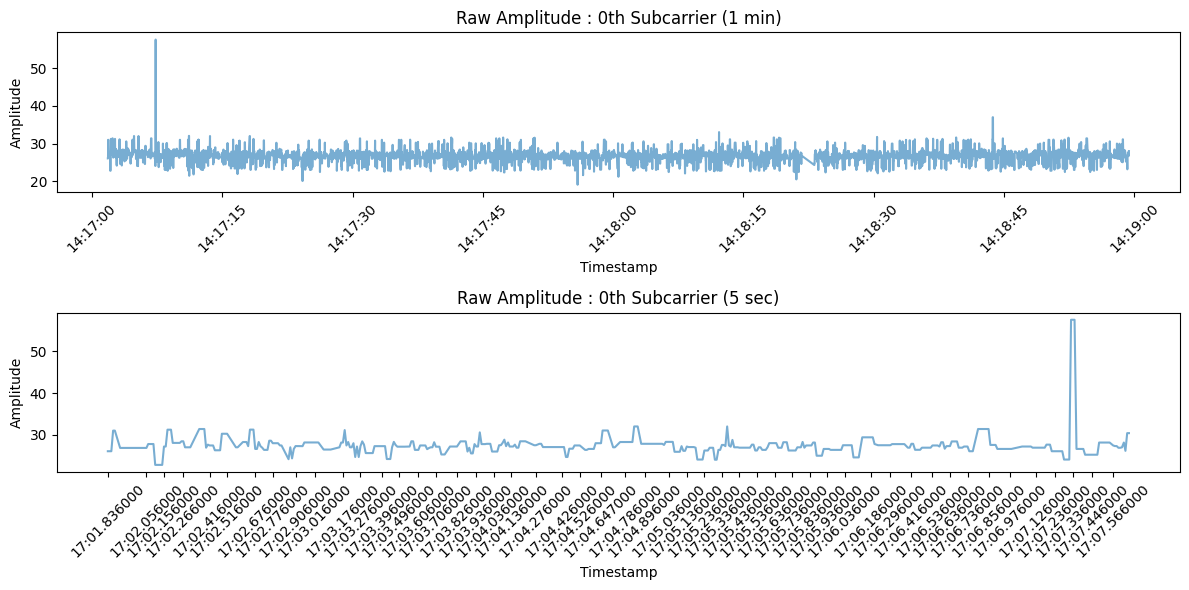

In [3]:
# cell 3 : 0번 서브캐리어 시각화
target_idx = 0
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(df['timestamp'], amp[:, target_idx], alpha=0.6)
plt.title("Raw Amplitude : 0th Subcarrier (1 min)")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
# 포맷 수정: 분:초.밀리초
plt.xticks( rotation=45)

plt.subplot(2,1,2)
plt.plot(ts, amp[:N, target_idx], alpha=0.6)
plt.title("Raw Amplitude : 0th Subcarrier (5 sec)")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
# 포맷 수정: 분:초.밀리초
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)

plt.tight_layout()
plt.show()


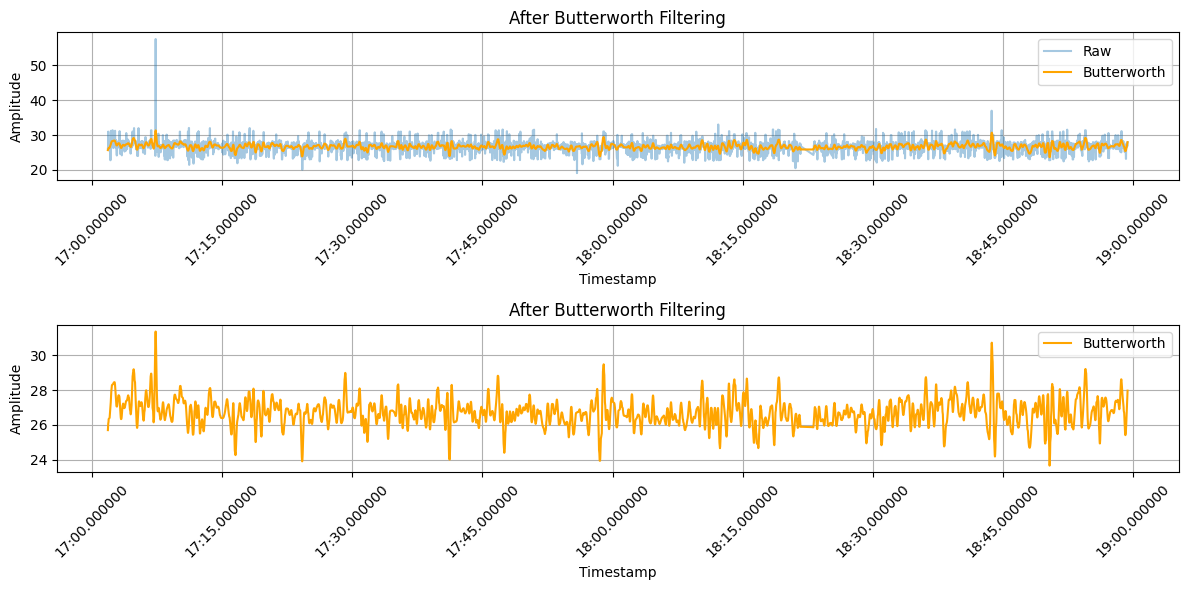

In [4]:
# Cell 4: Butterworth Low-Pass Filter
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# # 예시 코드
# ts_diff = np.diff(df['timestamp']).astype('timedelta64[ms]').astype(float)
# avg_interval_ms = np.mean(ts_diff)
# fs = 1000 / avg_interval_ms  # ms → Hz 변환

fs = 100
cutoff = 3.0
filtered_butter = butter_lowpass_filter(amp[:, target_idx], cutoff, fs)
plt.figure(figsize=(12, 6))

plt.subplot(2,1,1)
plt.plot(df['timestamp'], amp[:, target_idx], label='Raw', alpha=0.4)
plt.plot(df['timestamp'], filtered_butter, label='Butterworth', color='orange')
plt.title("After Butterworth Filtering")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(df['timestamp'], filtered_butter, label='Butterworth', color='orange')
plt.title("After Butterworth Filtering")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()



Butterworth Low-Pass Filtering 결과
1. 전처리 목적
    * 고주파 잡음(스파이크, 지글거림 등)을 제거하고 신호를 부드럽게 만들기 위해
2. 시각화 결과 특이점
    * 전반적인 형태는 Raw와 유사하지만, 급격히 튀는 값이 완화됨
3. 전처리 설명
    * Butterworth 필터는 매우 부드러운 저역통과 필터
    * 설정: cutoff = 3.0 Hz, fs = 100 Hz, order = 4

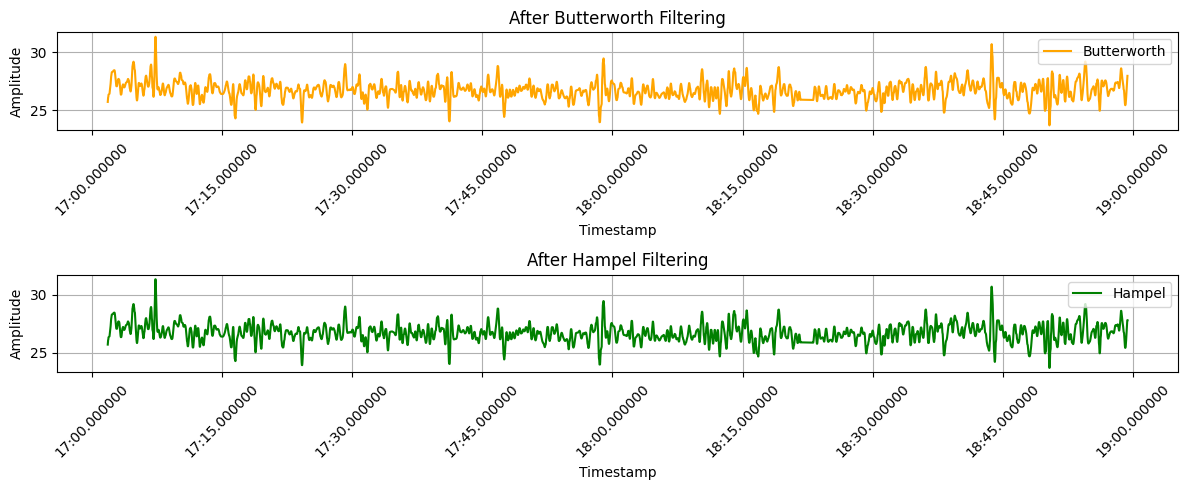

In [5]:
# Cell 5: Hampel Filter 적용
def hampel_filter(col, window=5, n_sigma=3):
    """Hampel filter로 이상치 제거"""
    median = medfilt(col, kernel_size=window)
    dev    = np.abs(col - median)
    mad    = np.median(dev)
    out    = dev > n_sigma * mad
    col[out] = median[out]
    return col

filtered_hampel = hampel_filter(filtered_butter.copy())

plt.figure(figsize=(12, 5))

plt.subplot(2,1,1)
plt.plot(df['timestamp'], filtered_butter, label='Butterworth', color='orange')
plt.title("After Butterworth Filtering")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(df['timestamp'], filtered_hampel, label='Hampel', color='green')
plt.title("After Hampel Filtering")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


Hampel Filtering 결과
 1. 전처리 목적
    * 이상치 (스파이크)**를 제거하여 신호의 신뢰도 확보


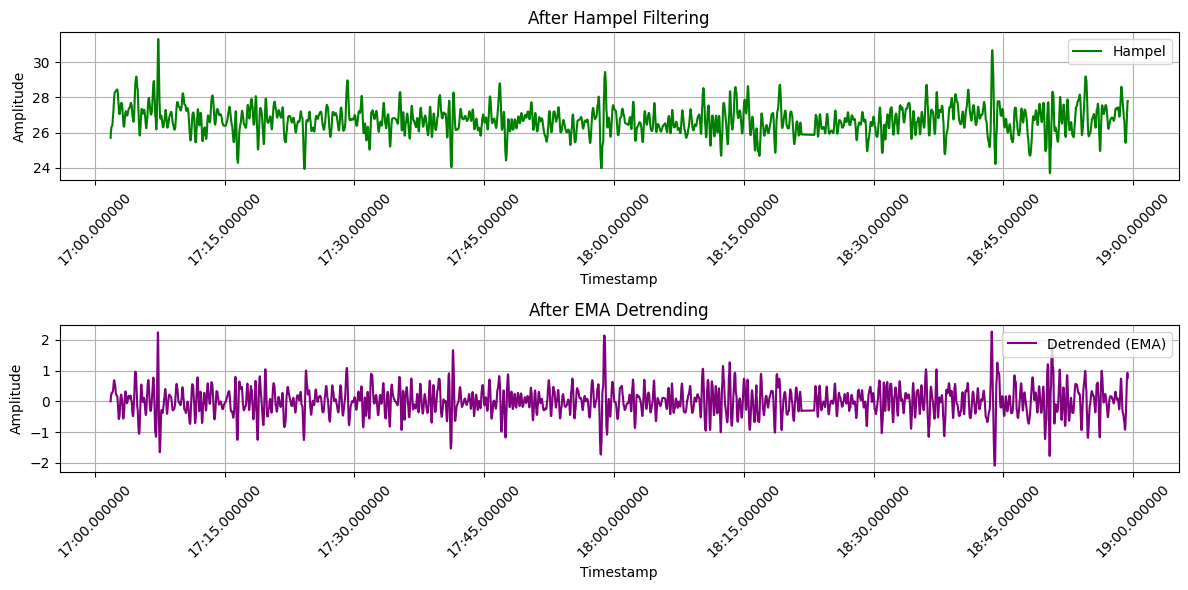

In [6]:
# Cell 6: EMA Detrending
ema_window = 20
ema = pd.Series(filtered_hampel).ewm(span=ema_window).mean()
detrended = filtered_hampel - ema

plt.figure(figsize=(12, 6))

plt.subplot(2,1,1)
plt.plot(df['timestamp'], filtered_hampel, label='Hampel', color='green')
plt.title("After Hampel Filtering")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(df['timestamp'], detrended, label='Detrended (EMA)', color='purple')
plt.title("After EMA Detrending")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(rotation=45)
plt.grid(True)


plt.tight_layout()
plt.show()


EMA Detrending 결과
1. 전처리 목적
    * 전체적인 드리프트(추세)**를 제거하여 이벤트 시점에서만 튀도록 만듦
    * baseline을 따라가면서 위아래 흔들리는 문제 제거
 2. 시각화 결과 특이점
    * 이전보다 중심선에 가까운 파형
   

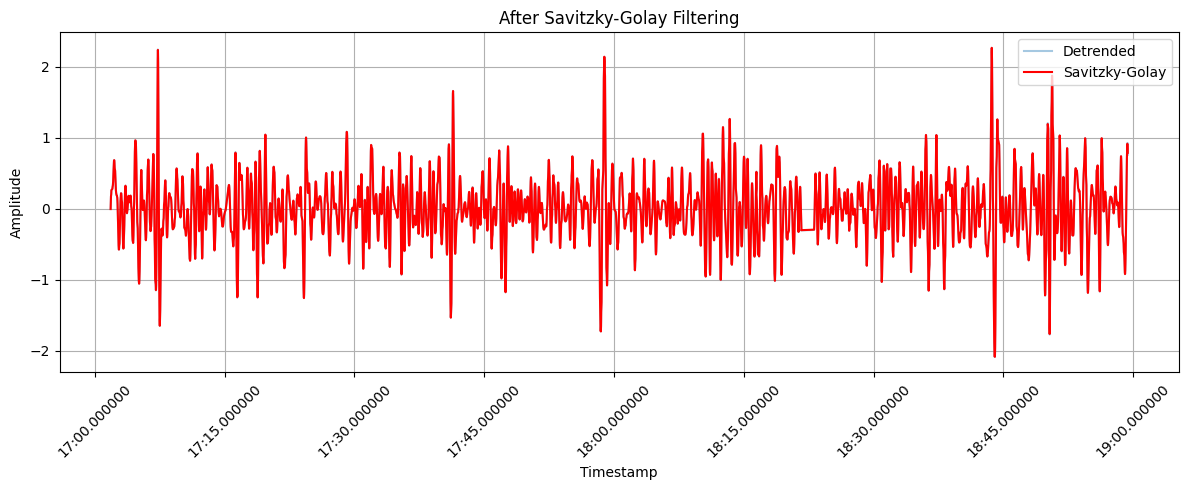

In [7]:
# Cell 7: Savitzky-Golay Smoothing
smoothed = savgol_filter(detrended, window_length=11, polyorder=2)

plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], detrended, label='Detrended', alpha=0.4)
plt.plot(df['timestamp'], smoothed, label='Savitzky-Golay', color='red')
plt.title("After Savitzky-Golay Filtering")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
